In [1]:
# Add related paths to system path
import sys
sys.path.append("../src")

import numpy as np
import pandas
import matplotlib.pyplot as plt
from models import FDBaseline, PDABaseline, CDABaseline, linearUCB
from evaluate import Evaluator

In [2]:
# Load data
data = pandas.read_csv("../data/data.csv", delimiter=',')
print(data.shape)

(5528, 87)


In [3]:
# Define baseline models
fixed = FDBaseline(1) # Define fixed dosage to be 1 (5mg / day)
pharm = PDABaseline()
clinic = CDABaseline()

In [4]:
# Get data for all baselines

# Fixed dosage baseline
fixed_features = fixed.get_features(data)

# Pharmacogenetic dosage baseline
pharm_features = pharm.get_features(data)

# Clinical dosage baseline
clinic_features = clinic.get_features(data)

# Get targets for each set (same targets for each baseline)
targets = fixed.get_targets(data)

In [5]:
# Define evaluators for each model
fixed_eval = Evaluator(fixed)
pharm_eval = Evaluator(pharm)
clinic_eval = Evaluator(clinic)

Fraction of correct decisions: 0.611794500723589


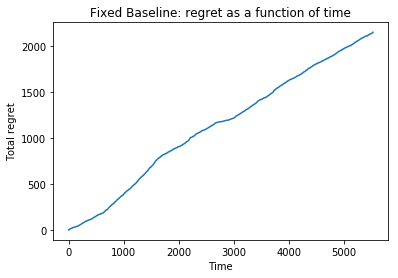

In [6]:
# Evaluate fixed baseline
fixed_predictions = fixed.predict(fixed_features)
fixed_acc = fixed_eval.accuracy(fixed_predictions, targets.values)
print("Fraction of correct decisions: " + str(fixed_acc))

fixed_regret = fixed_eval.regret(fixed_predictions, targets.values)
plt.plot(range(fixed_regret.shape[0]), fixed_regret)
plt.title("Fixed Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.6864387593389178


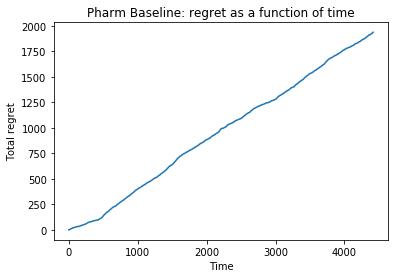

In [7]:
# Evaluate Pharmacogenetic baseline
pharm_predictions = pharm.predict(pharm_features.values[~np.isnan(pharm_features).any(axis=1)])
pharm_acc = pharm_eval.accuracy(pharm_predictions, targets.values[~np.isnan(pharm_features).any(axis=1)])
print("Fraction of correct decisions: " + str(pharm_acc))

pharm_regret = fixed_eval.regret(pharm_predictions, targets.values)
plt.plot(range(pharm_regret.shape[0]), pharm_regret)
plt.title("Pharm Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.649083088068825


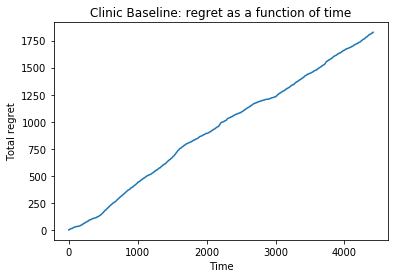

In [8]:
# Evaluate Clinical baseline
clinic_predictions = clinic.predict(clinic_features.values[~np.isnan(clinic_features).any(axis=1)])
clinic_acc = clinic_eval.accuracy(clinic_predictions, targets.values[~np.isnan(clinic_features).any(axis=1)])
print("Fraction of correct decisions: " + str(clinic_acc))

clinic_regret = fixed_eval.regret(clinic_predictions, targets.values)
plt.plot(range(clinic_regret.shape[0]), clinic_regret)
plt.title("Clinic Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

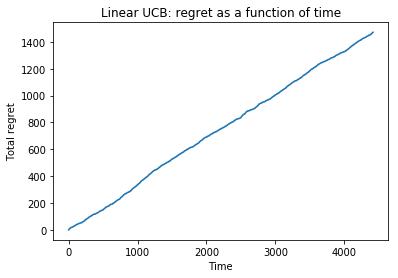

0.6668175645088275


In [9]:
linear_UCB = linearUCB(num_arms=3, alpha=0.5)
linear_UCB_features = linear_UCB.get_features(data)
linear_UCB_regret, linear_UCB_incorrect = linear_UCB.train(linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)], targets.values[~np.isnan(linear_UCB_features).any(axis=1)])
plt.plot(range(linear_UCB_regret.shape[0]), linear_UCB_regret)
plt.title("Linear UCB: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

print(1 - linear_UCB_regret[len(linear_UCB_regret) -1] / len(linear_UCB_regret))

In [10]:
print(linear_UCB_incorrect)

[0.5578446909667195, 0.38397102105501474, 0.3459361557618293, 0.35884084220058865, 0.3429929816617614, 0.38148064297034184, 0.34140819560787866, 0.3375594294770206, 0.3384650215078107, 0.34072900158478603, 0.33914421553090335, 0.34208738963097124, 0.3425401856463663, 0.33710663346162556, 0.3445777677156441, 0.3635952003622368, 0.36653837446230475, 0.36382159836993433, 0.36812316051618743, 0.3706135386008603, 0.368349558523885, 0.34004980756169345, 0.33665383744623045, 0.33778582748471814, 0.33710663346162556, 0.33778582748471814, 0.3321258772922798, 0.3348426533846502, 0.3239755490151687, 0.3232963549920761, 0.3253339370613539, 0.3255603350690514, 0.3251075390536563, 0.32374915100747115, 0.32239076296128594, 0.32691872311523656, 0.32601313108444646, 0.326239529092144, 0.32578673307674894, 0.3251075390536563, 0.32691872311523656, 0.32669232510753904, 0.32669232510753904, 0.3242019470228662, 0.32374915100747115, 0.3251075390536563]
